# Player Position Imputation
Needed installs: Torch Gemoetric

In [1]:
import os
os.chdir("..")
import ImputationModel.SuwonLSTMFunctions as SLF
import UtilFunctions.util_functions as util_functions
import UtilFunctions.plot_functions as plot_functions
import UtilFunctions.pitch_control as mpc
import ImputationModel.model_functions as mf
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools

import torch
from torch import nn
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv

import ImputationModel.Models.Time_LSTM_Module as TLSTM_module
import ImputationModel.Models.Time_LSTM as TLSTM
import ImputationModel.Models.GNN as GNN
import ImputationModel.Models.Agent_Imputer as AgentImputer
import ImputationModel.Models.Baselines as BL

fps = 30.

C:\Apps\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Section 1: Loading in the data
Step 1: Load in the available games

Step 2: Get event & tracking dataframes for all games

Step 3: Construct dataframe using the feature set described in the paper

Step 4: Sort the DataFrame by event so we get all players for each event in blocks

Step 5: Normalize the data

Step 6: Get data sequences to pass into the model

### Step 1: Load in the available games

In [2]:
suwon_match_df = pd.read_csv('data/Suwon_FC/Suwon_games.csv')
suwon_match_df.head(3)

,id,date,home_id,away_id,home_score,away_score
0,26223,2021-02-27 16:30:00+09:00,4644,4220,1,1
1,26238,2021-03-07 16:30:00+09:00,316,4220,3,0
2,26334,2021-03-10 19:30:00+09:00,4220,328,0,0


### Step 2: Get Event and Tracking dataframes for all games

In [3]:
events_dfs = []
tracking_dfs = []
home_dfs = []
away_dfs = []
formation_dfs = []
num_games = 2
count=0
for i in range(1,num_games+1):
    events_df, tracking_df, home_df, away_df, formation_df = util_functions.get_suwon_dataframes('game'+str(i))
    events_df['id'] = range(count,count+len(events_df))
    count+=len(events_df)
    events_dfs.append(events_df)
    tracking_dfs.append(tracking_df)
    home_dfs.append(home_df)
    away_dfs.append(away_df)
    formation_dfs.append(formation_df)

### Step 3: Construct dataframe using the feature set described in the paper

In [ ]:
whole_num_input = pd.DataFrame()
whole_cat_input = pd.DataFrame()
whole_input = pd.DataFrame()
whole_label = np.empty((0,2), float)
for i in range(0,2):
    num_input, cat_input, label,tdf,edf,input_data = SLF.get_game_data(events_dfs[i],tracking_dfs[i],home_dfs[i],away_dfs[i],util_functions.get_goalkeepers(home_dfs[i],away_dfs[i]), formation_dfs[i])
    whole_input = whole_input.append(input_data)
    whole_label = np.append(whole_label,label,axis=0)

### Step 4: Sort the DataFrame by event so we get all players for each event in blocks

In [5]:
sorted_whole_input_df, sorted_labels = SLF.custom_sort(whole_input, whole_label)
sorted_whole_input_df = sorted_whole_input_df.reset_index(drop=True)
sorted_whole_input_df

,ballx,prev_player_x,next_player_x,bally,prev_player_y,next_player_y,time_since_last_pred,prev_player_time,next_player_time,event_id,match_id,event_time,player_id,position,event_type,team_on_ball,player_on_ball,goal_diff,av_player_x,av_player_y
0,52.37337,2.253835,2.253835,34.298724,31.664812,31.664812,68.0,999932.0,158340.0,0,26223,1812,62082,GK,Pass,True,False,0,8.753473,31.488437
1,52.37337,33.843810,33.843810,34.298724,6.885748,6.885748,68.0,999932.0,5464.0,0,26223,1812,62110,LWB,Pass,True,False,0,51.047447,7.685294
2,52.37337,30.176055,30.176055,34.298724,18.139816,18.139816,68.0,999932.0,3072.0,0,26223,1812,145708,CB,Pass,True,False,0,35.942379,21.815694
3,52.37337,22.138935,22.138935,34.298724,30.233140,30.233140,68.0,999932.0,9026.0,0,26223,1812,77524,CB,Pass,True,False,0,38.519588,42.009405
4,52.37337,25.535895,25.535895,34.298724,50.389428,50.389428,68.0,999932.0,11720.0,0,26223,1812,62086,CB,Pass,True,False,0,46.537016,27.683475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98467,104.01748,20.126295,20.126295,31.321412,21.565928,21.565928,702.0,163075.0,999932.0,4491,26238,5649612,77578,CDM,Save,False,False,3,49.645850,37.956366
98468,104.01748,93.905070,93.905070,31.321412,33.818100,33.818100,702.0,702.0,999932.0,4491,26238,5649612,77583,CAM,Save,False,False,3,65.725143,38.108641
98469,104.01748,65.830905,65.830905,31.321412,35.278604,35.278604,702.0,155777.0,999932.0,4491,26238,5649612,187323,LF,Save,False,False,3,63.473393,23.255912
98470,104.01748,105.000000,105.000000,31.321412,68.000000,68.000000,702.0,454805.0,999932.0,4491,26238,5649612,188256,RF,Save,False,False,3,64.474843,50.974463


### Optional Step - Load in pre-saved data

In [6]:
#sorted_whole_input_df = pd.read_csv('sorted_whole_input_df_time.csv')
#sorted_labels = torch.tensor(np.array(pd.read_csv('swid_labels.csv')))

### Step 5: Normalize the data

In [7]:
time_scaler = RobustScaler()
timestamps = torch.tensor(time_scaler.fit_transform(np.array(sorted_whole_input_df['time_since_last_pred']).reshape(-1,1))).reshape(-1)
sorted_wi_num = sorted_whole_input_df[['ballx','prev_player_x','next_player_x','bally','prev_player_y','next_player_y','av_player_x','av_player_y','time_since_last_pred','prev_player_time','next_player_time']]
sorted_wi_cat = sorted_whole_input_df[['position','event_type','team_on_ball','player_on_ball','goal_diff']]
input_data_normalized, label_data_normalized, scaler = SLF.preprocess_data(sorted_wi_num, sorted_wi_cat, sorted_labels)

### Step 6: Create seqeuences from the data

In [8]:
X_ss, y_mm, ts, out_inds = SLF.split_sequences(sorted_whole_input_df, input_data_normalized, label_data_normalized, timestamps, 2, 2)

# Section 2: Create Training/Testing Data

In [9]:
#Create folds (e.g. data to put into the test set) based on match ids
fold1=sorted_whole_input_df[sorted_whole_input_df['match_id'].isin([26223])].index
fold2=sorted_whole_input_df[sorted_whole_input_df['match_id'].isin([26441, 26386, 42921])].index

"""Folds used in paper:
fold1=sorted_whole_input_df[sorted_whole_input_df['match_id'].isin([42926, 42937, 42945])].index
fold2=sorted_whole_input_df[sorted_whole_input_df['match_id'].isin([26441, 26386, 42921])].index
fold3=sorted_whole_input_df[sorted_whole_input_df['match_id'].isin([26423, 26428, 26433])].index
fold4=sorted_whole_input_df[sorted_whole_input_df['match_id'].isin([26223, 26238, 26334])].index
fold5=sorted_whole_input_df[sorted_whole_input_df['match_id'].isin([26248, 26255, 26257])].index"""

#Split data into train and test data
X_train, X_test, y_train, y_test, X_train_ts, X_test_ts = SLF.get_train_test_split(sorted_whole_input_df, X_ss, y_mm, ts, fold1)

#Put into format of 22 event sequences for an event (representing each player) and put into data loaders
train_data = SLF.series_data(X_train, y_train, X_train_ts, 25)
test_data = SLF.series_data(X_test, y_test, X_test_ts, 25)
train_loader = DataLoader(train_data,shuffle=False,batch_size=128)
test_loader = DataLoader(test_data,shuffle=False,batch_size=128)

Create edge index for fully connected graph network

In [10]:
#Connects players to every other player in the graph neural network
t1 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
list_edges = list(itertools.product(t1, t1))
for l in list_edges:
    if l[0] == l[1]:
        list_edges.remove(l)
list_edges = [list(ele) for ele in list_edges]

# Section 3: Load and Run Models
Model Types:

1. Agent Imputer - AgentImputer.AgentImputer
2. Time-LSTM = TLSTM.Time_LSTM
3. GNN = GNN.GNN

### Step 1: Load Models

In [11]:
model = AgentImputer.AgentImputer(input_size = X_train[0].shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)

### Step 2: Train the model

In [12]:
model, y_preds = mf.model_training(train_loader, X_train_ts, model, optimizer, list_edges, 10)

epoch:   0 loss: 0.28445667
epoch:   1 loss: 0.28113255
epoch:   2 loss: 0.26146334
epoch:   3 loss: 0.21973537
epoch:   4 loss: 0.18393181
epoch:   5 loss: 0.16322796
epoch:   6 loss: 0.14808895
epoch:   7 loss: 0.13904630
epoch:   8 loss: 0.13998094
epoch:   9 loss: 0.14281227
epoch:   9 loss: 0.1428122669


### Step 3: Make Model Predictions

In [13]:
actual_predictions, actual_test_results = mf.get_test_predictions(test_loader, model, y_test, list_edges, scaler)

# Section 4: Model Analysis

Function which calculates and shows the error in predictions for train or test data

In [14]:
def prediction_analytics(actual_predictions, actual_test_results, num_preds):
    actual_predictions = actual_predictions.reshape(num_preds,2)
    actual_test_results = actual_test_results.reshape(num_preds,2)
    plt.plot(actual_predictions)
    plt.plot(actual_test_results)
    plt.show()
    
    print("Dist: ", np.mean([np.linalg.norm(actual_predictions[i]-np.array(actual_test_results[i])) for i in range(len(actual_predictions))]))
    print("X Dist: ", np.mean(abs(actual_predictions[:,0] - np.array(actual_test_results[:,0]))))
    print("Y Dist: ", np.mean(abs(actual_predictions[:,1] - np.array(actual_test_results[:,1]))))
    return np.mean([np.linalg.norm(actual_predictions[i]-np.array(actual_test_results[i])) for i in range(len(actual_predictions))]),np.mean(abs(actual_predictions[:,0] - np.array(actual_test_results[:,0]))),np.mean(abs(actual_predictions[:,1] - np.array(actual_test_results[:,1])))

### Step 1: Show accuracy for test data

Test data Results: 


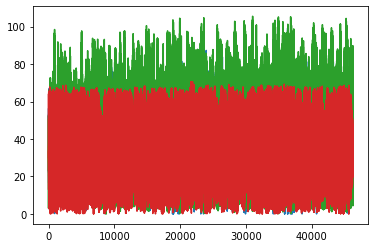

Dist:  10.788337339109548
X Dist:  7.455958440664788
Y Dist:  6.2504365347042885


(10.788337339109548, 7.455958440664788, 6.2504365347042885)

In [15]:
print("Test data Results: ")
prediction_analytics(actual_predictions, actual_test_results, y_test.shape[0])

### Step 2: Show accuracy for train data

Train data Results: 


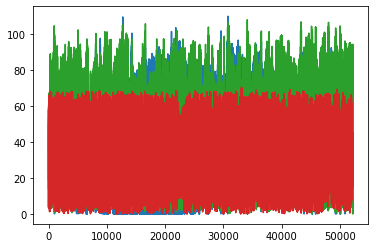

Dist:  10.605091725888958
X Dist:  7.075828968162563
Y Dist:  6.393486491606952


(10.605091725888958, 7.075828968162563, 6.393486491606952)

In [16]:
train_preds = [t.tolist() for t in y_preds]
actual_train_preds = scaler.inverse_transform(np.array([item for sublist in train_preds for item in sublist]).reshape(y_train.shape[0],2))
print("Train data Results: ")
prediction_analytics(actual_train_preds,scaler.inverse_transform(y_train),y_train.shape[0])

# Section 5: Generate and run Baseline Models

### Get data setup

In [17]:
base_x_train,base_x_train_cat,base_x_test,base_x_test_cat,base_y_train,base_y_test,xg_cat_train,xg_cat_test = BL.get_baseline_data(sorted_whole_input_df, sorted_labels, fold1)

### Baseline 1 - Average Seen Location

In [18]:
print("Baseline 1 distance error: ", BL.baseline_1(base_x_test.copy(), base_y_test)[0])
print("Baseline 1 distance error Train: ", BL.baseline_1(base_x_train.copy(), base_y_train)[0])

#Load results for baseline 1 and stores prediction in dataframe
#Duplicate code for other baseline models if you are looking to save baseline results for other models
_,b1_results = BL.baseline_1(base_x_test.copy(),base_y_test)
b1_results[['act_x','act_y']] = base_y_test
b1_results = b1_results.reset_index(drop=True)
b1_results['dist'] = [np.linalg.norm(np.array(b1_results.loc[i][['pred_x','pred_y']])-base_y_test[i]) for i in range(len(base_y_test))]
b1_results

X Error: 13.726591058396973
Y Error: 9.52469056596956
Baseline 1 distance error:  18.35232721670774
X Error: 14.4312311377
Y Error: 9.545122154588709
Baseline 1 distance error Train:  18.981075399730297
X Error: 13.726591058396973
Y Error: 9.52469056596956


,ballx,prev_player_x,next_player_x,bally,prev_player_y,next_player_y,av_player_x,av_player_y,time_since_last_pred,player_id,event_id,player_on_ball,prev_player_time,next_player_time,pred_x,pred_y,act_x,act_y,dist
0,52.373370,2.253835,2.253835,34.298724,31.664812,31.664812,8.753473,31.488437,68.0,62082,0,False,999932.0,158340.0,2.253835,31.664812,3.36,33.47,2.117145
1,52.373370,33.843810,33.843810,34.298724,6.885748,6.885748,51.047447,7.685294,68.0,62110,0,False,999932.0,5464.0,33.843810,6.885748,37.33,14.26,8.156783
2,52.373370,30.176055,30.176055,34.298724,18.139816,18.139816,35.942379,21.815694,68.0,145708,0,False,999932.0,3072.0,30.176055,18.139816,29.05,21.58,3.619788
3,52.373370,22.138935,22.138935,34.298724,30.233140,30.233140,38.519588,42.009405,68.0,77524,0,False,999932.0,9026.0,22.138935,30.233140,28.59,33.73,7.337865
4,52.373370,25.535895,25.535895,34.298724,50.389428,50.389428,46.537016,27.683475,68.0,62086,0,False,999932.0,11720.0,25.535895,50.389428,31.66,43.82,8.981205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46217,14.677005,72.887955,72.887955,34.430644,17.454104,17.454104,53.899955,24.061446,3572.0,62109,2106,False,10773.0,1000000.0,72.887955,17.454104,17.43,36.73,58.712392
46218,14.677005,81.771585,81.771585,34.430644,55.365464,55.365464,55.206585,39.823723,3572.0,62101,2106,False,254237.0,1000000.0,81.771585,55.365464,14.30,37.65,69.758530
46219,14.677005,65.201640,65.201640,34.430644,31.579268,31.579268,66.110184,34.586497,3572.0,62112,2106,False,30072.0,1000000.0,65.201640,31.579268,51.05,38.55,15.775298
46220,14.677005,85.389045,85.389045,34.430644,22.939596,22.939596,73.436738,36.092526,3572.0,187276,2106,False,15687.0,1000000.0,85.389045,22.939596,45.97,37.37,41.977347


### Baseline 2 - Time-Scaled Average Seen Location

In [19]:
print("Baseline 2 distance error: ", BL.baseline_2(base_x_test.copy(), base_y_test)[1])
print("Baseline 2 distance error train: ", BL.baseline_2(base_x_train.copy(), base_y_train)[1])

X Error: 13.176661233282358
Y Error: 9.383831381325946
Baseline 2 distance error:  17.76845912726873
X Error: 13.632756477671622
Y Error: 9.333400180764768
Baseline 2 distance error train:  18.170601960698743


### Baseline 3 - Average Player Location Over a Game

In [20]:
b3_preds = np.array(base_x_test[['av_player_x','av_player_y']])
print("X error: ", np.mean(abs(b3_preds[:,0].reshape(len(b3_preds),1)-base_y_test[:,0].reshape(len(b3_preds),1))))
print("Y error: ", np.mean(abs(b3_preds[:,1].reshape(len(b3_preds),1)-base_y_test[:,1].reshape(len(b3_preds),1))))
print("Distance error: ", np.mean([np.linalg.norm(b3_preds[i]-base_y_test[i]) for i in range(len(b3_preds))]))

b3_preds_train = np.array(base_x_train[['av_player_x','av_player_y']])
print("X error train: ", np.mean(abs(b3_preds_train[:,0].reshape(len(b3_preds_train),1)-base_y_train[:,0].reshape(len(b3_preds_train),1))))
print("Y error train: ", np.mean(abs(b3_preds_train[:,1].reshape(len(b3_preds_train),1)-base_y_train[:,1].reshape(len(b3_preds_train),1))))
print("Distance error train: ", np.mean([np.linalg.norm(b3_preds_train[i]-base_y_train[i]) for i in range(len(b3_preds_train))]))

X error:  14.197583974368616
Y error:  10.105767660338241
Distance error:  19.016805610894693
X error train:  14.749268277022384
Y error train:  9.229474681927805
Distance error train:  18.941518421058067


### Baseline 4 - XGBoost Baseline

In [21]:
xg_results, xg_preds = BL.xg_boost_baseline(base_x_train, xg_cat_train, base_x_test, xg_cat_test, base_y_train, base_y_test)
print("XGBoost Regressor Distance Error: ", xg_results)

C:\Apps\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Apps\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training
X:  4.547889570403019
Y:  3.97504208581775
Error:  6.68986261755257
Testing
X:  6.315449119780002
Y:  5.819404755444474
Error:  9.511265024712417
XGBoost Regressor Distance Error:  9.511265024712417


##### View the XGboost predictions

In [22]:
xgboost_df = base_x_test
xgboost_df[['pred_x','pred_y']] = xg_preds
xgboost_df[['act_x','act_y']] = base_y_test
xgboost_df['dist'] = [math.dist(xgboost_df.iloc[i][['pred_x','pred_y']],xgboost_df.iloc[i][['act_x','act_y']]) for i in range(len(xgboost_df))]

### Extra Information
To view the results of these models and use them to perform downstream tasks you must: Store the results of these in a csv dataframe, including the predicted and actual locations of players along with the original dataset. This then must be stored in a file available for access by the Experiments notebook.

Example:

In [23]:
xgboost_df

,ballx,prev_player_x,next_player_x,bally,prev_player_y,next_player_y,av_player_x,av_player_y,time_since_last_pred,player_id,event_id,player_on_ball,prev_player_time,next_player_time,pred_x,pred_y,act_x,act_y,dist
0,52.373370,2.253835,2.253835,34.298724,31.664812,31.664812,8.753473,31.488437,68.0,62082,0,False,999932.0,158340.0,16.587280,28.950811,3.36,33.47,13.977983
1,52.373370,33.843810,33.843810,34.298724,6.885748,6.885748,51.047447,7.685294,68.0,62110,0,False,999932.0,5464.0,46.844273,17.310188,37.33,14.26,9.991248
2,52.373370,30.176055,30.176055,34.298724,18.139816,18.139816,35.942379,21.815694,68.0,145708,0,False,999932.0,3072.0,37.815922,26.809568,29.05,21.58,10.207339
3,52.373370,22.138935,22.138935,34.298724,30.233140,30.233140,38.519588,42.009405,68.0,77524,0,False,999932.0,9026.0,36.899334,36.240723,28.59,33.73,8.680366
4,52.373370,25.535895,25.535895,34.298724,50.389428,50.389428,46.537016,27.683475,68.0,62086,0,False,999932.0,11720.0,41.033012,36.303993,31.66,43.82,12.014313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46217,14.677005,72.887955,72.887955,34.430644,17.454104,17.454104,53.899955,24.061446,3572.0,62109,2106,False,10773.0,1000000.0,41.219238,27.612665,17.43,36.73,25.476531
46218,14.677005,81.771585,81.771585,34.430644,55.365464,55.365464,55.206585,39.823723,3572.0,62101,2106,False,254237.0,1000000.0,29.101194,31.965086,14.30,37.65,15.855397
46219,14.677005,65.201640,65.201640,34.430644,31.579268,31.579268,66.110184,34.586497,3572.0,62112,2106,False,30072.0,1000000.0,46.452190,32.969925,51.05,38.55,7.230290
46220,14.677005,85.389045,85.389045,34.430644,22.939596,22.939596,73.436738,36.092526,3572.0,187276,2106,False,15687.0,1000000.0,55.760010,31.098793,45.97,37.37,11.626363


In [24]:
#xgboost_df.to_csv('xgboost_preds_time.csv')